<h1 align="center">Global Workload Balancing</h1>
<center>by Brandon Nohara</center>

# Table of Contents<a class="anchor" id="top"></a>
1. [Intro](#intro)
2. [Data Collection](#data_collection)
3. [Data Cleaning](#data_cleaning)
4. [Exploratory Data Analysis](#exploratory_data_analysis)
5. [Projecting Future Task Volume](#projecting_future_task_volume)
6. [Project Task Transfer Allotment](#project_task_transfer_allotment)
7. [Wrap-up](#wrapup)

# Intro <a class="anchor" id="intro"></a>

Our team has staff in 3 regions, let's call them region A, B, and C. Over time, certain regions have encountered bandwidth limits. Meanwhile, other regions had relatively lower workload. When this happens, we want to reassign tasks from the high workload region to a lower workload region. In this project, we'll do the following:
1. Look at some simple methods for projecting task count in the near future
2. Provide a framework for determining the capacity for each region
3. Calculate how many tasks to transfer between regions to achieve balanced volume

[Back to top](#top)

# Data Collection<a class="anchor" id="data_collection"></a>

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import statsmodels.api as sm

%matplotlib inline

Data sources:
* *tasks_external.csv* - We query this info from our tasks table. This gives us the number of weekly tasks for each region.
* *headcount_proj_external.csv* - We get this from the team leads. They update this info in a Google Sheet as hiring plans change. This shows us the planned head count for each role for each region. There are 2 roles, we'll call them role 1 and 2. Each role has a different capacity (how many tasks they should be taking each month).

In [3]:
tasks = pd.read_csv('tasks_external.csv')
headcount_proj = pd.read_csv('headcount_proj_external.csv')

print("Tasks Sample:")
print(tasks.head())

print("\nHeadcount Projection:")
headcount_proj

Tasks Sample:
     region      date  year  month  day year_week  task_count
0  region_a  1/1/2020  2020      1    1   2020_01           5
1  region_a  1/2/2020  2020      1    2   2020_01          25
2  region_a  1/5/2020  2020      1    5   2020_01          20
3  region_a  1/6/2020  2020      1    6   2020_02          20
4  region_a  1/7/2020  2020      1    7   2020_02          25

Headcount Projection:


,date_start,region_a_role_1,region_a_role_2,region_b_role_1,region_b_role_2,region_c_role_1,region_c_role_2
0,5/30/2021,10,0,10,4,12,6
1,6/6/2021,10,2,10,6,12,6
2,6/13/2021,10,2,14,6,12,6
3,6/20/2021,10,2,14,6,12,8
4,6/27/2021,10,2,14,6,12,8
5,7/4/2021,10,4,14,6,14,8
6,7/11/2021,10,4,14,6,14,8
7,7/18/2021,10,4,14,6,14,8


[Back to top](#top)

# Data Cleaning<a class="anchor" id="data_cleaning"></a>
1. Convert dates from string to datetime
2. Adjust format of year-week_num column to allow for proper sorting
3. Rearrange columns and sort rows for ease of use
4. Check for tasks with no region

## 1. Convert dates from string to datetime

In [4]:
tasks['date_pd'] = pd.to_datetime(tasks['date'])
tasks.drop(['date'], axis = 1, inplace = True)
tasks.rename(columns = {"date_pd":"date"}, inplace = True)

headcount_proj['date_start_pd'] = pd.to_datetime(headcount_proj['date_start'])
headcount_proj.drop(['date_start'], axis = 1, inplace = True)
headcount_proj.rename(columns = {"date_start_pd":"date_start"}, inplace = True)

## 2. Adjust format of year-week_num column to allow for proper sorting

In [5]:
tasks['week_num'] = tasks['date'].dt.isocalendar().week.astype(int)

In [6]:
# When converting week_num to a string, need to add an extra zero in front of weeks 1-9
# This will allow us to sort year-week_num properly
for index, row in tasks.iterrows():
    if row['week_num'] >= 10:
        tasks.loc[index, 'year-week_num'] = str(row['year']) + '-' + str(row['week_num'])
    else:
        tasks.loc[index, 'year-week_num'] = str(row['year']) + '-0' + str(row['week_num'])

## 3. Rearrange columns and sort rows for ease of use

In [7]:
tasks = tasks[['region', 'date', 'year', 'month', 'day', 'week_num', 'year-week_num', 'task_count']]
tasks.sort_values(by=['region', 'date'], inplace=True)

headcount_proj = headcount_proj[['date_start', 'region_a_role_1', 'region_a_role_2', 'region_b_role_1', 'region_b_role_2', 'region_c_role_1', 'region_c_role_2']]

## 4. Check for tasks with no region

In [8]:
tasks[tasks.year == 2021].groupby(by=['region', 'year', 'month'])['task_count'].sum()

region    year  month
None      2021  1          30
                2         130
                3         285
                4          55
                5          20
region_a  2021  1        1715
                2        1995
                3        2890
                4        3210
                5        2885
region_b  2021  1        2350
                2        3425
                3        3475
                4        3085
                5        2765
region_c  2021  1        2390
                2        3560
                3        4730
                4        4845
                5        4245
Name: task_count, dtype: int64

In [9]:
# As long as tasks with region of None represent a small portion of total task volume,
# will remove these from the analysis to keep things clean.
tasks = tasks[tasks.region != 'None']

[Back to top](#top)

# Exploratory Data Analysis<a class="anchor" id="exploratory_data_analysis"></a>

1. Historical Task Volume By Region
2. Year Over Year Task Volume Comparison

## 1. Historical Task Volume By Region

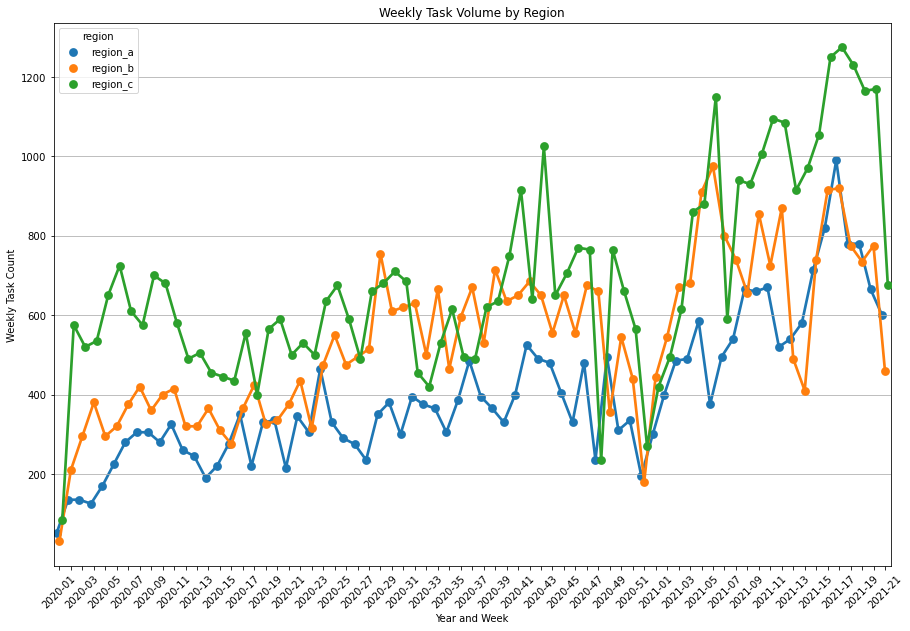

In [11]:
tasks_weekly = tasks.query('week_num != 53')
tasks_weekly = tasks_weekly.groupby(by = ['region', 'year', 'week_num', 'year-week_num']).sum()
tasks_weekly.reset_index(inplace = True)
tasks_weekly.sort_values(by = ['year-week_num'], inplace = True)

plt.figure(figsize = [15, 10])
plt.yticks(ticks = [200, 400, 600, 800, 1000, 1200, 1400])
plt.xticks(rotation = 45)
plt.grid(b = True)
plt.title('Weekly Task Volume by Region')
g = sb.pointplot(data = tasks_weekly, x = 'year-week_num', y = 'task_count', hue = 'region', dodge = 0.5, ci = None)
plt.ylabel('Weekly Task Count')
plt.xlabel('Year and Week')

for ind, label in enumerate(g.get_xticklabels()):
    if ind % 2 == 0:  # every 2nd date on x-axis is displayed to make it more readable
        label.set_visible(True)
    else:
        label.set_visible(False);

## 2. Year Over Year Task Volume Comparison

See if last year had the same volume trend. If so, we can base the 2021 volume projection on this.

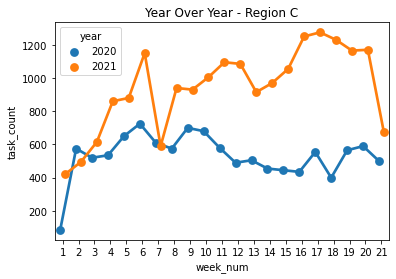

In [12]:
tasks_weekly_region_c = tasks_weekly.query("region == 'region_c' & week_num <= 21")

plt.title('Year Over Year - Region C')
sb.pointplot(data = tasks_weekly_region_c, x = 'week_num', y = 'task_count', hue = 'year', dodge = 0.3, ci = None);

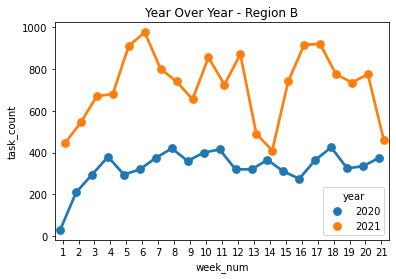

In [13]:
tasks_weekly_region_b = tasks_weekly.query("region == 'region_b' & week_num <= 21")

plt.title('Year Over Year - Region B')
sb.pointplot(data = tasks_weekly_region_b, x = 'week_num', y = 'task_count', hue = 'year', dodge = 0.3, ci = None);

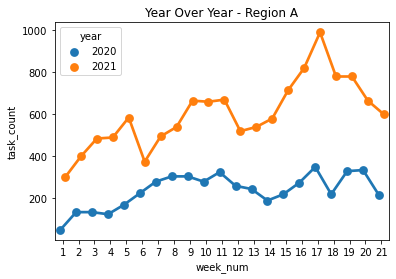

In [14]:
tasks_weekly_region_a = tasks_weekly.query("region == 'region_a' & week_num <= 21")

plt.title('Year Over Year - Region A')
sb.pointplot(data = tasks_weekly_region_a, x = 'week_num', y = 'task_count', hue = 'year', dodge = 0.3, ci = None);

## Observations

* Each region shows a trend of increasing task volume over time.
* For each region, the trend looks different from 2020 to 2021. We probably don't want to model the year over year trend to predict future task count.

[Back to top](#top)

# Projecting Future Task Volume<a class="anchor" id="projecting_future_task_volume"></a>

1. Linear regression
2. Moving average

## 1. Linear Regression

Linear regression of tasks for each region using data for 2020. If the fit is good, will assume the same slope for the corresponding weeks in 2021.

### Region C

In [15]:
tasks_weekly_region_c = tasks_weekly.query("region == 'region_c' & year == 2020 & week_num >= 22 & week_num <= 29")

for index, row in tasks_weekly_region_c.iterrows():
    tasks_weekly_region_c.loc[index, 'intercept'] = 1

lm_region_c = sm.OLS(tasks_weekly_region_c['task_count'], tasks_weekly_region_c[['intercept', 'week_num']])
results_region_c = lm_region_c.fit()
results_region_c.summary()

C:\Users\bnohara\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\bnohara\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\bnohara\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continui

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             task_count   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1.902
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.217
Time:                        17:14:27   Log-Likelihood:                -44.677
No. Observations:                   8   AIC:                             93.35
Df Residuals:                       6   BIC:                             93.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    191.2500    293.962      0.651      0.539    -528.049     910.549
week_num      15.8333     11.482      1.379      0.217     -12.261      43.928
==============================================================================
Omnibus:                        1.405   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                0.560
Skew:                          -0.620   Prob(JB):                        0.756
Kurtosis:                       2.622   Cond. No.                         287.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Region B

In [16]:
tasks_weekly_region_b = tasks_weekly.query("region == 'region_b' & year == 2020 & week_num >= 22 & week_num <= 29")

for index, row in tasks_weekly_region_b.iterrows():
    tasks_weekly_region_b.loc[index, 'intercept'] = 1

lm_region_b = sm.OLS(tasks_weekly_region_b['task_count'], tasks_weekly_region_b[['intercept', 'week_num']])
results_region_b = lm_region_b.fit()
results_region_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             task_count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     8.157
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0290
Time:                        17:15:25   Log-Likelihood:                -45.939
No. Observations:                   8   AIC:                             95.88
Df Residuals:                       6   BIC:                             96.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -477.1429    344.172     -1.386      0.215   -1319.300     365.015
week_num      38.3929     13.443      2.856      0.029       5.500      71.286
==============================================================================
Omnibus:                        2.395   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                0.836
Skew:                           0.184   Prob(JB):                        0.658
Kurtosis:                       1.459   Cond. No.                         287.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Region A

In [17]:
tasks_weekly_region_a = tasks_weekly.query("region == 'region_a' & year == 2020 & week_num >= 22 & week_num <= 29")

for index, row in tasks_weekly_region_a.iterrows():
    tasks_weekly_region_a.loc[index, 'intercept'] = 1
    
lm_region_a = sm.OLS(tasks_weekly_region_a['task_count'], tasks_weekly_region_a[['intercept', 'week_num']])
results_region_a = lm_region_a.fit()
results_region_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             task_count   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.100
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.335
Time:                        17:16:18   Log-Likelihood:                -43.962
No. Observations:                   8   AIC:                             91.92
Df Residuals:                       6   BIC:                             92.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    605.1786    268.809      2.251      0.065     -52.573    1262.930
week_num     -11.0119     10.499     -1.049      0.335     -36.703      14.679
==============================================================================
Omnibus:                        3.953   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                1.567
Skew:                           1.082   Prob(JB):                        0.457
Kurtosis:                       2.857   Cond. No.                         287.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion
Linear regression for region B shows some promise, but overall these models are not a good fit using only the week number as a feature. In the future, we could evaluate other features like month of year, request type, and number of people on the stakeholder teams. Due to time constraints at the moment though, I'm going to move on to a simple moving average.

## 2. Moving Average

For each region, look at average weekly task count for the past 2 weeks.

In [18]:
# Manually set the effective 'today' date to get full weeks of data in the calculations.
# In the future, can probably clean this up.
today_effective = dt.datetime(2021,6,1)
#today_effective = dt.datetime.today().date()

date_start_str = (today_effective - dt.timedelta(days=15)).strftime('%Y-%m-%d')
date_end_str = (today_effective - dt.timedelta(days=2)).strftime('%Y-%m-%d')

tasks_mov_avg = tasks[['date', 'region', 'week_num', 'task_count']].query('date >= @date_start_str & date <= @date_end_str')
tasks_mov_avg = tasks_mov_avg.groupby(['region', 'week_num']).sum()
tasks_mov_avg_weekly = tasks_mov_avg.groupby(['region']).mean()

task_count_region_a = tasks_mov_avg_weekly.query('region == "region_a"').loc['region_a']['task_count']
task_count_region_b = tasks_mov_avg_weekly.query('region == "region_b"').loc['region_b']['task_count']
task_count_region_c = tasks_mov_avg_weekly.query('region == "region_c"').loc['region_c']['task_count']

# See if there's a more elegant way to set the dates here
task_proj = {
    'date_start': [
        (today_effective - dt.timedelta(days=2)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=5)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=12)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=19)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=26)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=33)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=40)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=47)).strftime('%Y-%m-%d'),
    ],
    'date_end': [
        (today_effective + dt.timedelta(days=4)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=11)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=18)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=25)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=32)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=39)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=46)).strftime('%Y-%m-%d'),
        (today_effective + dt.timedelta(days=53)).strftime('%Y-%m-%d'),
    ]
}

df_task_proj = pd.DataFrame(task_proj, columns = ['date_start', 'date_end'])

arr_tasks_region_a = np.repeat(task_count_region_a, len(df_task_proj))
arr_tasks_region_b = np.repeat(task_count_region_b, len(df_task_proj))
arr_tasks_region_c = np.repeat(task_count_region_c, len(df_task_proj))

df_task_proj['tasks_region_a'] = arr_tasks_region_a.tolist()
df_task_proj['tasks_region_b'] = arr_tasks_region_b.tolist()
df_task_proj['tasks_region_c'] = arr_tasks_region_c.tolist()

df_task_proj

,date_start,date_end,tasks_region_a,tasks_region_b,tasks_region_c
0,2021-05-30,2021-06-05,632.5,617.5,922.5
1,2021-06-06,2021-06-12,632.5,617.5,922.5
2,2021-06-13,2021-06-19,632.5,617.5,922.5
3,2021-06-20,2021-06-26,632.5,617.5,922.5
4,2021-06-27,2021-07-03,632.5,617.5,922.5
5,2021-07-04,2021-07-10,632.5,617.5,922.5
6,2021-07-11,2021-07-17,632.5,617.5,922.5
7,2021-07-18,2021-07-24,632.5,617.5,922.5


### Conclusion

For now, will use moving average for the past 2 weeks for the task projection (and for the remainder of this analysis). This method is relatively naive and requires weekly updates. If we can fit a better model, we can adjust the analysis accordingly.

[Back to top](#top)

# Project Task Transfer Allotment Between Regions<a class="anchor" id="project_task_transfer_allotment"></a>

1. Project the number of capacity slots for tasks
2. Project the number of tasks per capacity slot. This is what we want to balance across regions.
3. Project tasks to transfer between regions

## 1. Determine the number of capacity slots

Role 1 counts as 1 slot, role 2 counts as 2 slots. This is based on the guideline that people in role 2 should be assigned double the number of tasks as someone in role 1.

In [19]:
for index, row in headcount_proj.iterrows():
    headcount_proj.loc[index, 'slots_region_a'] = row['region_a_role_1'] + row['region_a_role_2']*2
    headcount_proj.loc[index, 'slots_region_b'] = row['region_b_role_1'] + row['region_b_role_2']*2
    headcount_proj.loc[index, 'slots_region_c'] = row['region_c_role_1'] + row['region_c_role_2']*2

headcount_proj = headcount_proj[['date_start', 'slots_region_a', 'slots_region_b', 'slots_region_c']]
headcount_proj

C:\Users\bnohara\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\bnohara\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,date_start,slots_region_a,slots_region_b,slots_region_c
0,2021-05-30,10.0,18.0,24.0
1,2021-06-06,14.0,22.0,24.0
2,2021-06-13,14.0,26.0,24.0
3,2021-06-20,14.0,26.0,28.0
4,2021-06-27,14.0,26.0,28.0
5,2021-07-04,18.0,26.0,30.0
6,2021-07-11,18.0,26.0,30.0
7,2021-07-18,18.0,26.0,30.0


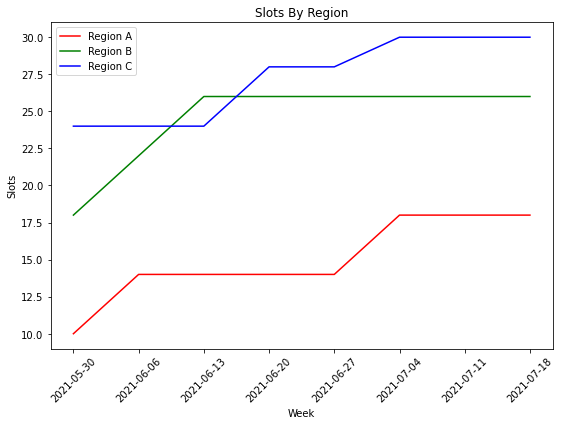

In [20]:
plt.figure(figsize=[9,6])
plt.plot(headcount_proj.date_start, headcount_proj['slots_region_a'], color='red')
plt.plot(headcount_proj.date_start, headcount_proj['slots_region_b'], color='green')
plt.plot(headcount_proj.date_start, headcount_proj['slots_region_c'], color='blue')
plt.legend(['Region A', 'Region B', 'Region C'])
plt.title('Slots By Region')
plt.ylabel('Slots')
plt.xlabel('Week')
plt.xticks(headcount_proj.date_start, rotation = 45);

## 2. Project the number of tasks per capacity slot

In [21]:
df_join = df_task_proj.set_index('date_start').join(headcount_proj.set_index('date_start'), how='left')
df_join['tasks_per_slot_region_a'] = df_join['tasks_region_a'] / df_join['slots_region_a']
df_join['tasks_per_slot_region_b'] = df_join['tasks_region_b'] / df_join['slots_region_b']
df_join['tasks_per_slot_region_c'] = df_join['tasks_region_c'] / df_join['slots_region_c']
df_join

,date_end,tasks_region_a,tasks_region_b,tasks_region_c,slots_region_a,slots_region_b,slots_region_c,tasks_per_slot_region_a,tasks_per_slot_region_b,tasks_per_slot_region_c
date_start,,,,,,,,,,
2021-05-30,2021-06-05,632.5,617.5,922.5,10.0,18.0,24.0,63.250000,34.305556,38.437500
2021-06-06,2021-06-12,632.5,617.5,922.5,14.0,22.0,24.0,45.178571,28.068182,38.437500
2021-06-13,2021-06-19,632.5,617.5,922.5,14.0,26.0,24.0,45.178571,23.750000,38.437500
2021-06-20,2021-06-26,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429
2021-06-27,2021-07-03,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429
2021-07-04,2021-07-10,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000
2021-07-11,2021-07-17,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000
2021-07-18,2021-07-24,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000


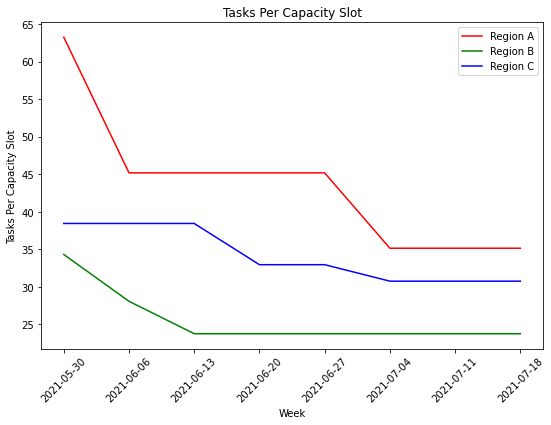

In [22]:
plt.figure(figsize=[9,6])
plt.plot(df_join.index, df_join['tasks_per_slot_region_a'], color='red')
plt.plot(df_join.index, df_join['tasks_per_slot_region_b'], color='green')
plt.plot(df_join.index, df_join['tasks_per_slot_region_c'], color='blue')
plt.legend(['Region A', 'Region B', 'Region C'])
plt.title('Tasks Per Capacity Slot')
plt.ylabel('Tasks Per Capacity Slot')
plt.xlabel('Week')
plt.xticks(df_join.index, rotation = 45);

## 3. Project tasks to transfer between regions

The key columns are the 'tasks_region_to_region' columns at the right. Here, we're allowing for triage between all regions. The priority is on minimizing the number of total tasks transferred.

In [23]:
# Possible Jupyter notebook bug. Need to set df_join again to get the cell below to work.
df_join = df_task_proj.set_index('date_start').join(headcount_proj.set_index('date_start'))
df_join['tasks_per_slot_region_a'] = df_join['tasks_region_a'] / df_join['slots_region_a']
df_join['tasks_per_slot_region_b'] = df_join['tasks_region_b'] / df_join['slots_region_b']
df_join['tasks_per_slot_region_c'] = df_join['tasks_region_c'] / df_join['slots_region_c']
df_join

,date_end,tasks_region_a,tasks_region_b,tasks_region_c,slots_region_a,slots_region_b,slots_region_c,tasks_per_slot_region_a,tasks_per_slot_region_b,tasks_per_slot_region_c
date_start,,,,,,,,,,
2021-05-30,2021-06-05,632.5,617.5,922.5,10.0,18.0,24.0,63.250000,34.305556,38.437500
2021-06-06,2021-06-12,632.5,617.5,922.5,14.0,22.0,24.0,45.178571,28.068182,38.437500
2021-06-13,2021-06-19,632.5,617.5,922.5,14.0,26.0,24.0,45.178571,23.750000,38.437500
2021-06-20,2021-06-26,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429
2021-06-27,2021-07-03,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429
2021-07-04,2021-07-10,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000
2021-07-11,2021-07-17,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000
2021-07-18,2021-07-24,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000


In [24]:
df_all_regions = df_join
df_all_regions['tasks_per_slot_avg'] = (df_join['tasks_per_slot_region_a'] + df_join['tasks_per_slot_region_b'] + df_join['tasks_per_slot_region_c']) / 3

# Adding columns that will indicate the number of tasks to transfer between specific regions at the end
new_cols = ['tasks_region_c_to_region_b', 'tasks_region_b_to_region_c', 'tasks_region_b_to_region_a', 'tasks_region_a_to_region_b', 'tasks_region_c_to_region_a', 'tasks_region_a_to_region_c']

for col in new_cols:
    df_all_regions[col] = np.zeros(len(df_all_regions))

for index, row in df_all_regions.iterrows():
    # Region A
    row['region_a_tasks_move_temp'] = row['tasks_per_slot_avg'] * row['slots_region_a'] - row['tasks_region_a']

    # Region B
    row['region_b_tasks_move_temp'] = row['tasks_per_slot_avg'] * row['slots_region_b'] - row['tasks_region_b']

    # Region C
    row['region_c_tasks_move_temp'] = row['tasks_per_slot_avg'] * row['slots_region_c'] - row['tasks_region_c']

    # Brute force way of getting 'tasks_move_temp' for each region to sum to zero.
    # See if there is a more elegant way to do this later.
    if row['region_a_tasks_move_temp'] > 0 and row['region_b_tasks_move_temp'] > 0 and row['region_c_tasks_move_temp'] <= 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = -(row['region_a_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_b_tasks_move_temp'])) * row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'region_b_tasks_move'] = -(row['region_a_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_b_tasks_move_temp'])) * row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'region_c_tasks_move'] = row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_c_to_region_b'] = -(row['region_b_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_b_tasks_move_temp'])) * row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_c_to_region_a'] = -(row['region_a_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_b_tasks_move_temp'])) * row['region_c_tasks_move_temp']
    elif row['region_a_tasks_move_temp'] > 0 and row['region_b_tasks_move_temp'] <= 0 and row['region_c_tasks_move_temp'] > 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = -(row['region_a_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'region_b_tasks_move'] = row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'region_c_tasks_move'] = -(row['region_c_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_b_to_region_a'] = -(row['region_a_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_b_to_region_c'] = -(row['region_c_tasks_move_temp'] / (row['region_a_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_b_tasks_move_temp']
    elif row['region_a_tasks_move_temp'] > 0 and row['region_b_tasks_move_temp'] <= 0 and row['region_c_tasks_move_temp'] <= 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = -(row['region_b_tasks_move_temp'] + row['region_c_tasks_move_temp'])
        df_all_regions.loc[index, 'region_b_tasks_move'] = row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'region_c_tasks_move'] = row['region_c_tasks_move_temp']
        df_all_regoions.loc[index, 'tasks_region_c_to_region_a'] = -row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_b_to_region_a'] = -row['region_b_tasks_move_temp'] 
    elif row['region_a_tasks_move_temp'] <= 0 and row['region_b_tasks_move_temp'] > 0 and row['region_c_tasks_move_temp'] > 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'region_b_tasks_move'] = -(row['region_b_tasks_move_temp'] / (row['region_b_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'region_c_tasks_move'] = -(row['region_c_tasks_move_temp'] / (row['region_b_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_a_to_region_b'] = -(row['region_b_tasks_move_temp'] / (row['region_b_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_a_to_region_c'] = -(row['region_c_tasks_move_temp'] / (row['region_b_tasks_move_temp'] + row['region_c_tasks_move_temp'])) * row['region_a_tasks_move_temp']
    elif row['region_a_tasks_move_temp'] <= 0 and row['region_b_tasks_move_temp'] > 0 and row['region_c_tasks_move_temp'] <= 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'region_b_tasks_move'] = -(row['region_a_tasks_move_temp'] + row['region_c_tasks_move_temp'])
        df_all_regions.loc[index, 'region_c_tasks_move'] = row['region_c_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_a_to_region_b'] = -row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_c_to_region_b'] = -row['region_c_tasks_move_temp']
    elif row['region_a_tasks_move_temp'] <= 0 and row['region_b_tasks_move_temp'] <= 0 and row['region_c_tasks_move_temp'] > 0:
        df_all_regions.loc[index, 'region_a_tasks_move'] = row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'region_b_tasks_move'] = row['region_b_tasks_move_temp']
        df_all_regions.loc[index, 'region_c_tasks_move'] = -(row['region_a_tasks_move_temp'] + row['region_b_tasks_move_temp'])
        df_all_regions.loc[index, 'tasks_region_a_to_region_c'] = -row['region_a_tasks_move_temp']
        df_all_regions.loc[index, 'tasks_region_b_to_region_c'] = -row['region_b_tasks_move_temp']

df_all_regions

,date_end,tasks_region_a,tasks_region_b,tasks_region_c,slots_region_a,slots_region_b,slots_region_c,tasks_per_slot_region_a,tasks_per_slot_region_b,tasks_per_slot_region_c,tasks_per_slot_avg,tasks_region_c_to_region_b,tasks_region_b_to_region_c,tasks_region_b_to_region_a,tasks_region_a_to_region_b,tasks_region_c_to_region_a,tasks_region_a_to_region_c,region_a_tasks_move,region_b_tasks_move,region_c_tasks_move
date_start,,,,,,,,,,,,,,,,,,,,
2021-05-30,2021-06-05,632.5,617.5,922.5,10.0,18.0,24.0,63.250000,34.305556,38.437500,45.331019,0.000000,0.0,0.0,97.723112,0.0,81.466703,-179.189815,97.723112,81.466703
2021-06-06,2021-06-12,632.5,617.5,922.5,14.0,22.0,24.0,45.178571,28.068182,38.437500,37.228084,29.025974,0.0,0.0,111.306818,0.0,0.000000,-111.306818,140.332792,-29.025974
2021-06-13,2021-06-19,632.5,617.5,922.5,14.0,26.0,24.0,45.178571,23.750000,38.437500,35.788690,63.571429,0.0,0.0,131.458333,0.0,0.000000,-131.458333,195.029762,-63.571429
2021-06-20,2021-06-26,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429,33.958333,0.000000,0.0,0.0,141.932033,0.0,15.151300,-157.083333,141.932033,15.151300
2021-06-27,2021-07-03,632.5,617.5,922.5,14.0,26.0,28.0,45.178571,23.750000,32.946429,33.958333,0.000000,0.0,0.0,141.932033,0.0,15.151300,-157.083333,141.932033,15.151300
2021-07-04,2021-07-10,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000,29.879630,26.111111,0.0,0.0,94.666667,0.0,0.000000,-94.666667,120.777778,-26.111111
2021-07-11,2021-07-17,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000,29.879630,26.111111,0.0,0.0,94.666667,0.0,0.000000,-94.666667,120.777778,-26.111111
2021-07-18,2021-07-24,632.5,617.5,922.5,18.0,26.0,30.0,35.138889,23.750000,30.750000,29.879630,26.111111,0.0,0.0,94.666667,0.0,0.000000,-94.666667,120.777778,-26.111111


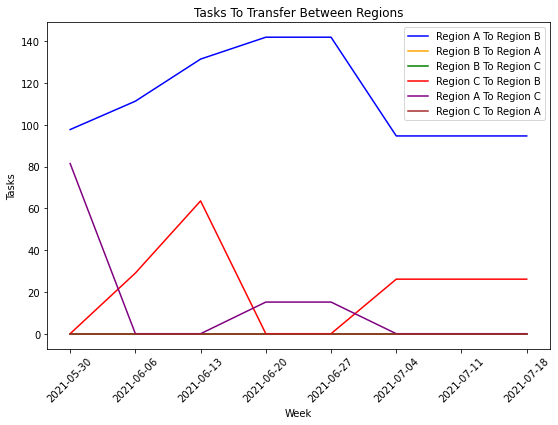

In [25]:
plt.figure(figsize=[9,6])
plt.plot(df_all_regions.index, df_all_regions['tasks_region_a_to_region_b'], color='blue')
plt.plot(df_all_regions.index, df_all_regions['tasks_region_b_to_region_a'], color='orange')
plt.plot(df_all_regions.index, df_all_regions['tasks_region_b_to_region_c'], color='green')
plt.plot(df_all_regions.index, df_all_regions['tasks_region_c_to_region_b'], color='red')
plt.plot(df_all_regions.index, df_all_regions['tasks_region_a_to_region_c'], color='purple')
plt.plot(df_all_regions.index, df_all_regions['tasks_region_c_to_region_a'], color='brown')
plt.legend(['Region A To Region B', 'Region B To Region A', 'Region B To Region C', 'Region C To Region B', 'Region A To Region C', 'Region C To Region A'])
plt.title('Tasks To Transfer Between Regions')
plt.ylabel('Tasks')
plt.xlabel('Week')
plt.xticks(df_all_regions.index, rotation = 45);

## Conclusion

We can use these projections to determine how many tasks can be triaged between regions in the coming weeks. Note that we are using a simple moving average to project task volume. The moving average looks at the previous two weeks and will be updated each week. Therefore at this time, the fluctuations in tasks to transfer between regions across weeks only depends on changes in headcount.

[Back to top](#top)

# Wrap-up<a class="anchor" id="wrapup"></a>

In this analysis, we used a simple moving average to project future task volume. There is opportunity to improve on this projection using something more dynamic like linear regression with more features. We also provided a framework for capacity slots to measure the capacity for each region, considering the number of people in role 1 and 2. Then we looked at differences in projected number of tasks per slot to calculate how many tasks could be triaged across regions to balance volumes. The visualizations presented in this analysis are also uploaded to an internal dashboard.

Representatives from each region periodically discuss the data and check in regarding each region's bandwidth. When necessary, the task transfer allotment between regions can be adjusted. Internal tooling has a feature enabling the task transfers between each region.

[Back to top](#top)